<a href="https://colab.research.google.com/github/YesidORC/Proyecto_DL_2024_1/blob/main/02_Preprocesado_y_Arquitectura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

Se procede a realizar la partición en train/validation/test.
Para este caso se procede de forma manual haciendo un 60% para train 20% para validation y 20% para test

Se realizará un análisis univariado - unistep

In [2]:
def train_val_test_split(serie, tr_size=0.6, vl_size=0.2, ts_size=0.2 ):
    # Definir número de datos en cada subserie
    N = serie.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = serie[0:Ntrain]
    val = serie[Ntrain:Ntrain+Nval]
    test = serie[Ntrain+Nval:]

    return train, val, test

In [3]:
def crear_dataset_supervisado(array, input_length, output_length):
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [4]:
file_path="https://raw.githubusercontent.com/YesidORC/Proyecto_DL_2024_1/main/TemperaturaEst202_2013_2022.csv"

In [5]:
df= pd.read_csv(file_path,index_col=0)
df.index = pd.to_datetime(df.index)
df.interpolate(method='time',inplace=True)
tr, vl, ts = train_val_test_split(df['Temperatura'])

In [6]:
df.isna().sum()

Temperatura    0
Calidad        0
dtype: int64

In [7]:
# Definición de los INPUT_LENGTH y OUTPUT_LENGTH
INPUT_LENGTH = 24
OUTPUT_LENGTH = 1   # momentos adelante a predecir

# Datasets supervisados para entrenamiento (x_tr, y_tr), validación (x_vl, y_vl) y prueba (x_ts, y_ts)
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [9]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (52563, 24, 1), y_tr: (52563, 1, 1)
Set de validación - x_vl: (17504, 24, 1), y_vl: (17504, 1, 1)
Set de prueba - x_ts: (17506, 24, 1), y_ts: (17506, 1, 1)


In [10]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

In [11]:
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

In [12]:
data_s, scaler = escalar_dataset(data_in)

In [13]:
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [ ]:
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()
N_UNITS = 80
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])
modelo = Sequential()
modelo.add(LSTM(N_UNITS,activation = 'relu',return_sequences= True,input_shape=INPUT_SHAPE))
modelo.add(LSTM(N_UNITS,activation = 'relu'))
modelo.add(Dense(OUTPUT_LENGTH))

In [19]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

optimizador = RMSprop(learning_rate=5e-5)
optimizador1 = 'adam'
optimizador2 = 'mse'
modelo.compile(optimizer = optimizador,loss =  root_mean_squared_error, metrics=['mean_absolute_error'])
# modelo.compile(optimizer='adam',loss = root_mean_squared_error, metrics=['mean_absolute_error']) # Adam, combina las ventajas de otros optimizadores como AdaGrad y RMSProp


In [20]:
EPOCHS = 80
BATCH_SIZE = 128
model = modelo.fit(x = x_tr_s,y = y_tr_s,batch_size = BATCH_SIZE,epochs = EPOCHS,validation_data = (x_vl_s, y_vl_s),verbose=2)


Epoch 1/80
411/411 - 29s - loss: 0.2864 - mean_absolute_error: 0.2381 - val_loss: 0.2609 - val_mean_absolute_error: 0.2218 - 29s/epoch - 71ms/step
Epoch 2/80
411/411 - 25s - loss: 0.2055 - mean_absolute_error: 0.1694 - val_loss: 0.1377 - val_mean_absolute_error: 0.1101 - 25s/epoch - 61ms/step
Epoch 3/80
411/411 - 25s - loss: 0.1184 - mean_absolute_error: 0.0900 - val_loss: 0.1121 - val_mean_absolute_error: 0.0857 - 25s/epoch - 60ms/step
Epoch 4/80
411/411 - 26s - loss: 0.1052 - mean_absolute_error: 0.0781 - val_loss: 0.1021 - val_mean_absolute_error: 0.0758 - 26s/epoch - 62ms/step
Epoch 5/80
411/411 - 26s - loss: 0.0946 - mean_absolute_error: 0.0699 - val_loss: 0.0865 - val_mean_absolute_error: 0.0642 - 26s/epoch - 64ms/step
Epoch 6/80
411/411 - 24s - loss: 0.0883 - mean_absolute_error: 0.0648 - val_loss: 0.0818 - val_mean_absolute_error: 0.0592 - 24s/epoch - 59ms/step
Epoch 7/80
411/411 - 23s - loss: 0.0848 - mean_absolute_error: 0.0619 - val_loss: 0.0774 - val_mean_absolute_error: 0.

In [21]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 80)            26240     
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 77841 (304.07 KB)
Trainable params: 77841 (304.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
final_accuracy = model.history["val_mean_absolute_error"]
print("FINAL ACCURACY MEAN: ", np.mean(final_accuracy))

FINAL ACCURACY MEAN:  0.04746109191328287


In [32]:
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr}')
# print(rmse_tr)
print(f'  RMSE val:\t {rmse_vl}')
# print(rmse_vl)
print(f'  RMSE test:\t {rmse_ts}')
# print(rmse_ts)

Comparativo desempeños:
  RMSE train:	 [0.05345683917403221, 0.03627355769276619]
  RMSE val:	 [0.055301226675510406, 0.03711232170462608]
  RMSE test:	 [0.057029616087675095, 0.03703676164150238]


<ipython-input-33-f7192e37d591>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


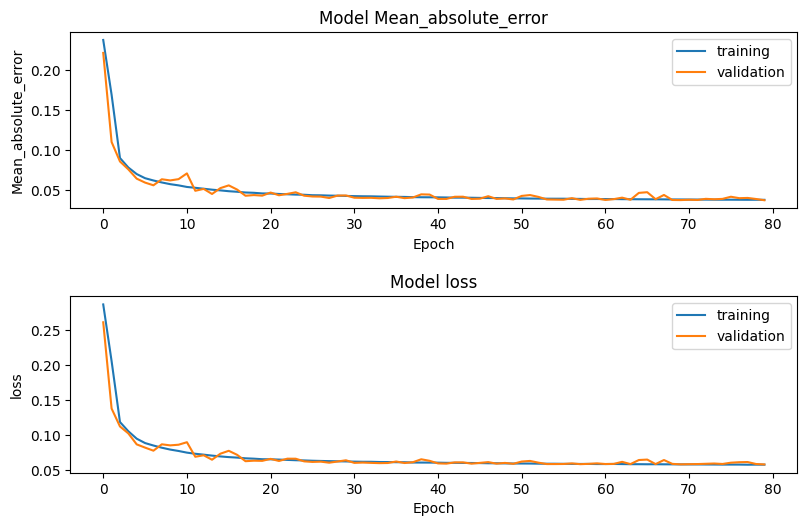

In [33]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('Epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(8,5))
plt.tight_layout()
display_training_curves(model.history['mean_absolute_error'], model.history['val_mean_absolute_error'], 'Mean_absolute_error', 211)
display_training_curves(model.history['loss'], model.history['val_loss'], 'loss', 212)
plt.subplots_adjust(hspace=0.5)

In [40]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=2)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

548/548 - 5s - 5s/epoch - 9ms/step


Text(0.5, 1.0, 'Error test menos test predicho')

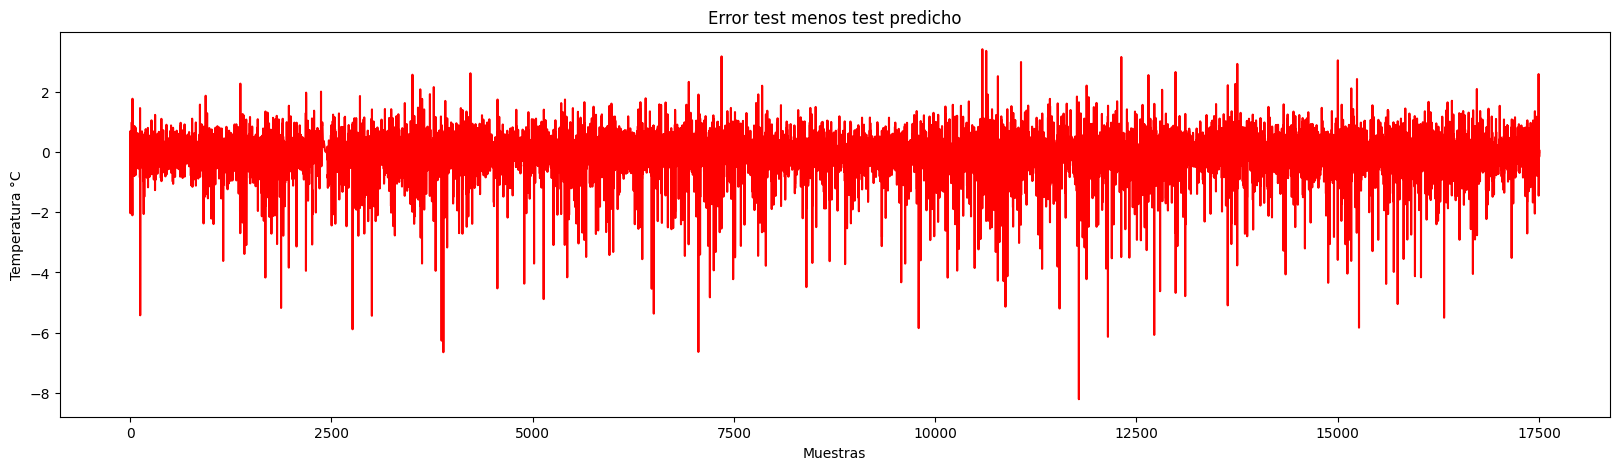

In [41]:
y_ts_pred = predecir(x_ts_s, modelo, scaler)
# N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
# ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.figure(figsize=(20,5))
plt.plot(errores,"r")
plt.ylabel("Temperatura °C")
plt.xlabel("Muestras")
plt.title("Error test menos test predicho")
